In [1]:
# Basic
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy

import pickle, os, glob, re, random
from tqdm import tqdm

from sklearn import preprocessing

# Model
import scipy
from scipy.special import entr
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.insert(1, './modules')
from utils import *
# from usad import * 

import torch
import torch.nn as nn
import torch.utils.data as data_utils

# Visualization
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# from matplotlib import font_manager, rc
# plt.rcParams['font.family'] = 'NanumGothic'
# import platform
# if platform.system() == 'Windows':
#     font_nasme = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
#     rc('font', family=font_name)
# else:    
#     rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rc('font', family='Malgun Gothic')

# Function

In [ ]:
device = get_default_device()

class Encoder(nn.Module):
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, int(in_size/2))
        self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
        self.linear3 = nn.Linear(int(in_size/4), latent_size)
        self.relu = nn.ReLU(True)
        
    def forward(self, w):
        out = self.linear1(w)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        z = self.relu(out)
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, int(out_size/4))
        self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
        self.linear3 = nn.Linear(int(out_size/2), out_size)
        self.relu = nn.ReLU(True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        out = self.linear1(z)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        w = self.sigmoid(out)
        return w
    
class UsadModel(nn.Module):
    def __init__(self, w_size, z_size):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)
        
    def training_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
        return loss1,loss2

    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
        loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
        return {'val_loss1': loss1, 'val_loss2': loss2}
    
    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = torch.stack(batch_losses1).mean()
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = torch.stack(batch_losses2).mean()
        return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))


def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

# Data
기계시설물을  동작시키는  모터가  동작할  때  발생하는 고유의 진동을 수집한 데이터([데이터 출처](https://aihub.or.kr/aidata/30748))

- 모터  외부에  진동센서를  부착하여  일정  시간  단위로  모터의  떨림  정도를 측정
- 모터 동력은 3.75KW 
- Sample Rate는  기본  4kHz로 1초당 4,000개의 sample들을 측정함  
- 3초간  측정하기 때문에 하나의 csv 파일마다 총 12,000개의 데이터가 들어있음
- 센서  데이터의  오류는 총 5개로 사용할 데이터의 오류 종류는 **축정렬불량**

불량 데이터 20,000개, 정상 데이터 100,000개 중 일부 subsampling

In [5]:
filepath = "./data/AI_herb"

In [9]:
df_normal = pd.read_csv(os.path.join(filepath, "df_normal_500.csv"))
df_failure = pd.read_csv(os.path.join(filepath, "df_failure_500.csv"))

In [10]:
df_normal.shape, df_failure.shape

((6000000, 2), (6000000, 2))

# USAD

(108000, 2)
(108000, 2)


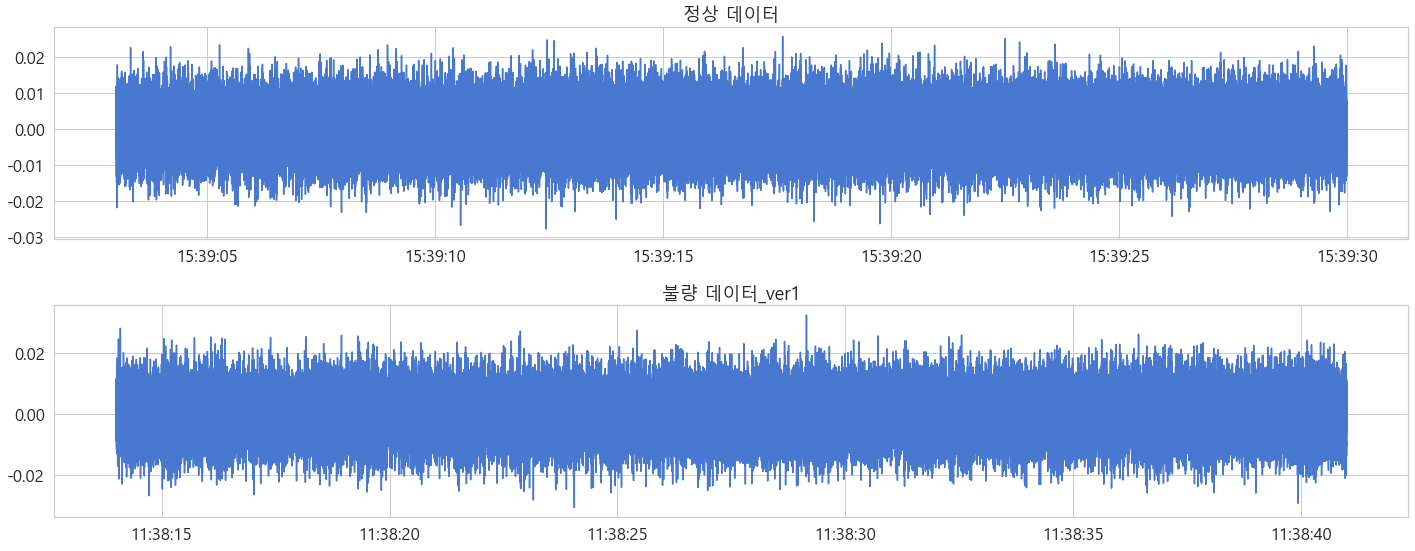

In [105]:
# 정상 데이터
fig, ax = plt.subplots(figsize=(20,8), ncols=1, nrows=2)
data = df_normal.iloc[24000:132000]
data['time'] = pd.to_datetime(data.time)
ax[0].plot(data.time, data.value)
ax[0].set_title('정상 데이터')
print(data.shape)


# 불량 데이터
data = df_failure.iloc[84000:192000]
data['time'] = pd.to_datetime(data.time)
ax[1].plot(data.time, data.value)
ax[1].set_title('불량 데이터_ver1')
print(data.shape)

plt.tight_layout()
plt.show()

(108000, 2)
(108000, 2)


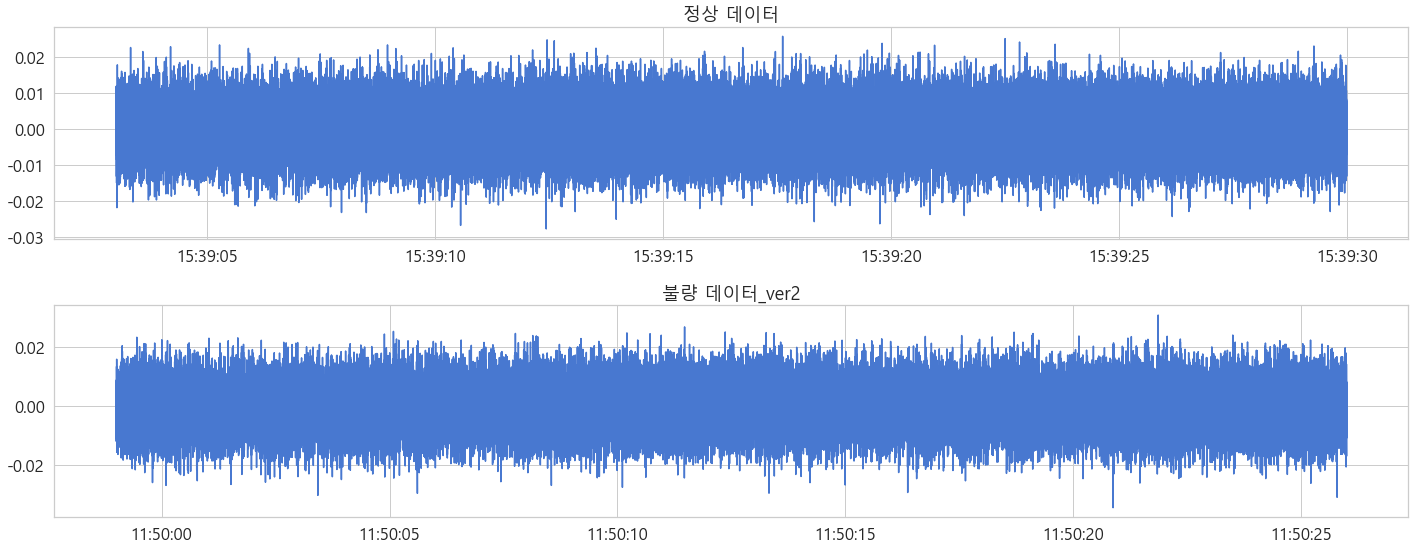

In [104]:
# 정상 데이터
fig, ax = plt.subplots(figsize=(20,8), ncols=1, nrows=2)
data = df_normal.iloc[24000:132000]
data['time'] = pd.to_datetime(data.time)
ax[0].plot(data.time, data.value)
ax[0].set_title('정상 데이터')
print(data.shape)


# 불량 데이터
data = df_failure.iloc[1596000:1704000]
data['time'] = pd.to_datetime(data.time)
ax[1].plot(data.time, data.value)
ax[1].set_title('불량 데이터_ver2')
print(data.shape)

plt.tight_layout()
plt.show()

In [106]:
normal = deepcopy(df_normal.iloc[24000:132000][['value']].reset_index(drop=True))
attack = deepcopy(df_failure.iloc[84000:192000][['value']].reset_index(drop=True))
attack2 = deepcopy(df_failure.iloc[1596000:1704000][['value']].reset_index(drop=True))
normal.shape, attack.shape, attack2.shape

((108000, 1), (108000, 1), (108000, 1))

In [107]:
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

for i in list(attack2):
    attack2[i]=attack2[i].apply(lambda x: str(x).replace("," , "."))
attack2 = attack2.astype(float)

In [108]:
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

x = attack2.values 
x_scaled = min_max_scaler.transform(x)
attack2 = pd.DataFrame(x_scaled)

In [109]:
window_size=12
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack2=attack2.values[np.arange(window_size)[None, :] + np.arange(attack2.shape[0]-window_size)[:, None]]
windows_normal.shape, windows_attack.shape, windows_attack2.shape

((107988, 12, 1), (107988, 12, 1), (107988, 12, 1))

## Train

In [112]:
BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [113]:
model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [17]:
# history = training(N_EPOCHS,model,train_loader,val_loader)

In [18]:
opt_func =torch.optim.Adam
epochs = N_EPOCHS

history = []
optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
for epoch in range(epochs):
    for [batch] in train_loader:
        batch=to_device(batch,device)

        #Train AE1
        loss1,loss2 = model.training_step(batch,epoch+1)
        loss1.backward()
        optimizer1.step()
        optimizer1.zero_grad()


        #Train AE2
        loss1,loss2 = model.training_step(batch,epoch+1)
        loss2.backward()
        optimizer2.step()
        optimizer2.zero_grad()


    result = evaluate(model, val_loader, epoch+1)
    model.epoch_end(epoch, result)
    history.append(result)

Epoch [0], val_loss1: 0.0163, val_loss2: 0.0158
Epoch [1], val_loss1: 0.0158, val_loss2: 0.0000
Epoch [2], val_loss1: 0.0155, val_loss2: -0.0051
Epoch [3], val_loss1: 0.0153, val_loss2: -0.0075
Epoch [4], val_loss1: 0.0151, val_loss2: -0.0090
Epoch [5], val_loss1: 0.0150, val_loss2: -0.0099
Epoch [6], val_loss1: 0.0149, val_loss2: -0.0106
Epoch [7], val_loss1: 0.0148, val_loss2: -0.0110
Epoch [8], val_loss1: 0.0147, val_loss2: -0.0114
Epoch [9], val_loss1: 0.0146, val_loss2: -0.0117
Epoch [10], val_loss1: 0.0146, val_loss2: -0.0119
Epoch [11], val_loss1: 0.0145, val_loss2: -0.0120
Epoch [12], val_loss1: 0.0145, val_loss2: -0.0122
Epoch [13], val_loss1: 0.0144, val_loss2: -0.0123
Epoch [14], val_loss1: 0.0144, val_loss2: -0.0125
Epoch [15], val_loss1: 0.0145, val_loss2: -0.0126
Epoch [16], val_loss1: 0.0143, val_loss2: -0.0126
Epoch [17], val_loss1: 0.0144, val_loss2: -0.0128
Epoch [18], val_loss1: 0.0144, val_loss2: -0.0128
Epoch [19], val_loss1: 0.0142, val_loss2: -0.0128
Epoch [20], 

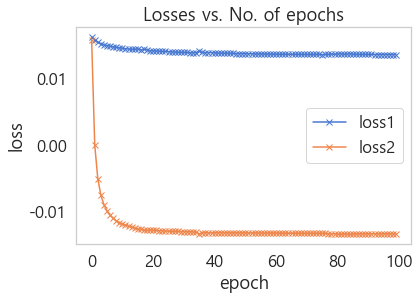

In [19]:
plot_history(history)

In [54]:
# torch.save({
#             'encoder': model.encoder.state_dict(),
#             'decoder1': model.decoder1.state_dict(),
#             'decoder2': model.decoder2.state_dict()
#             }, os.path.join("./model","usad_model_1.pth"))

## Test

In [114]:
checkpoint = torch.load(os.path.join("./model","usad_model_1.pth"))

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [66]:
results=testing(model,test_loader)
labels = attack.values

In [68]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [69]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [70]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

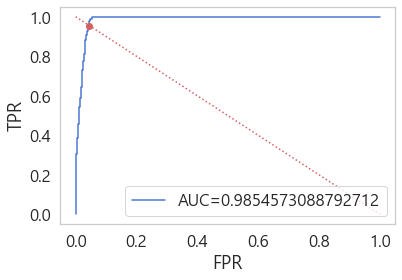

In [28]:
threshold=ROC(y_test,y_pred)

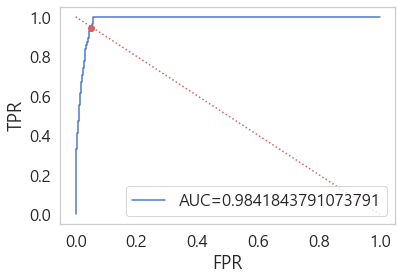

In [71]:
threshold=ROC(y_test,y_pred)

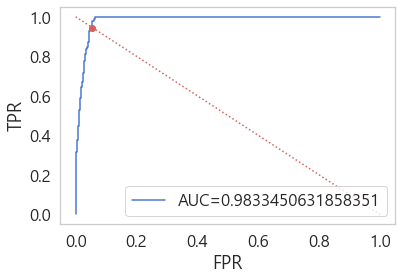

In [61]:
threshold=ROC(y_test,y_pred)

In [115]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack2).float().view(([windows_attack2.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
results=testing(model,test_loader)
labels = attack2.values

In [116]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [117]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [118]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

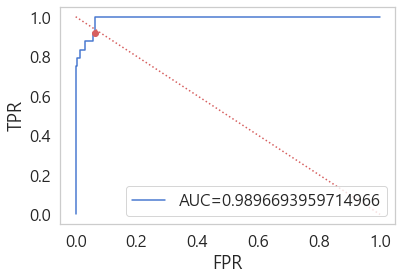

In [119]:
threshold=ROC(y_test,y_pred)

In [120]:
# pd.DataFrame(y_pred).to_csv(os.path.join(filepath, "y_pred_ver2_1.csv"), index=False)